<a href="https://colab.research.google.com/github/sul01/MSDS-CODE/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing

In [1]:
import numpy as np
import pandas as pd

#loading
BITSTREAMVERA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/BITSTREAMVERA.csv")
CENTURY = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/CENTURY.csv')
CONSOLAS = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/CONSOLAS.csv")
EBRIMA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/EBRIMA.csv")
GILL = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/GILL.csv')

#cleaning
drop_names = ["fontVariant","m_label","orientation","m_top","m_left","originalH","originalW","h","w"]
FONT = [BITSTREAMVERA, CENTURY, CONSOLAS, EBRIMA, GILL]; CL = []
for i in range(5):
  CL.append(FONT[i][(FONT[i]['strength']==0.4) & (FONT[i]['italic']==0)].drop(drop_names,axis=1))

#transforming
def fontToMatrix(font, df):
  for case in range(df.shape[0]):
    font[case] =  np.array(df[df.columns[3:]].iloc[case]).reshape(20,20)

FONT_mat = [] #font as 20x20 matrix
for i in range(5):
  FONT_mat.append(np.empty((CL[i].shape[0],20,20), int))
  fontToMatrix(FONT_mat[i], CL[i])

Examples

Bitstream



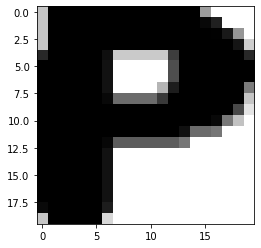

Century



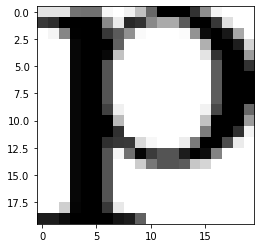

Consolas



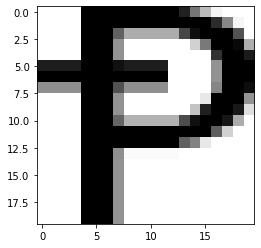

Ebrima



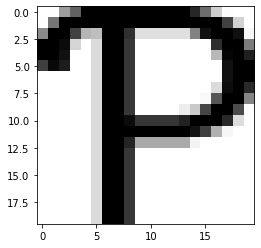

Gill



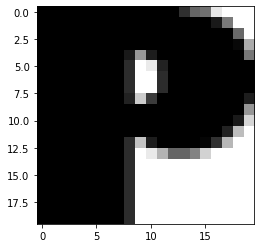

In [2]:
import matplotlib.pyplot as plt

print('Bitstream\n'); plt.imshow(FONT_mat[0][8], cmap=plt.cm.binary); plt.show() 
print('Century\n'); plt.imshow(FONT_mat[1][199], cmap=plt.cm.binary); plt.show() 
print('Consolas\n'); plt.imshow(FONT_mat[2][26], cmap=plt.cm.binary); plt.show() 
print('Ebrima\n'); plt.imshow(FONT_mat[3][1387], cmap=plt.cm.binary); plt.show() 
print('Gill\n'); plt.imshow(FONT_mat[4][243], cmap=plt.cm.binary); plt.show() 

train/test split

In [3]:
from sklearn.model_selection import train_test_split

def ypred(x, model):
  return list(map({0:'BITSTREAMVERA', 1:'CENTURY', 2:'CONSOLAS', 3:'EBRIMA', 4:'GILL'}.get, model.predict(x).argmax(axis = -1)))

dataX = np.concatenate(([FONT_mat[i] for i in range(5)])).reshape(-1,20,20,1)
dataY = np.concatenate(([CL[i]['font'] for i in range(5)]))
train, test = train_test_split(range(dataX.shape[0]), test_size = 0.2, random_state = 0)
x_train = dataX[train]; x_test = dataX[test]
y_train = dataY[train]; y_test = dataY[test]

#CNN

(https://www.tensorflow.org/tutorials/images/cnn)

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

#build (step 3)
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(20, 20, 1)))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu')) #100 chosen at random
model.add(layers.Dense(5))
#model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
monitor = model.fit(x_train, pd.Series(y_train,dtype='category').astype('category').cat.codes, epochs=20,
                    validation_data=(x_test, pd.Series(y_test, dtype='category').astype('category').cat.codes))

Epoch 1/20
245/245 [==============================] - 3s 12ms/step - loss: 9.3895 - accuracy: 0.3224 - val_loss: 1.5104 - val_accuracy: 0.4460
Epoch 2/20
245/245 [==============================] - 2s 10ms/step - loss: 1.4109 - accuracy: 0.4583 - val_loss: 1.3399 - val_accuracy: 0.4931
Epoch 3/20
245/245 [==============================] - 2s 10ms/step - loss: 1.1862 - accuracy: 0.5459 - val_loss: 1.2469 - val_accuracy: 0.5044
Epoch 4/20
245/245 [==============================] - 2s 10ms/step - loss: 1.1674 - accuracy: 0.5426 - val_loss: 1.1108 - val_accuracy: 0.5873
Epoch 5/20
245/245 [==============================] - 2s 10ms/step - loss: 0.9713 - accuracy: 0.6166 - val_loss: 1.0580 - val_accuracy: 0.6001
Epoch 6/20
245/245 [==============================] - 2s 10ms/step - loss: 0.9158 - accuracy: 0.6493 - val_loss: 1.0274 - val_accuracy: 0.6144
Epoch 7/20
245/245 [==============================] - 2s 10ms/step - loss: 0.8608 - accuracy: 0.6719 - val_loss: 0.9753 - val_accuracy: 0.6400

Performance during learning (currently incorrect for training sets)

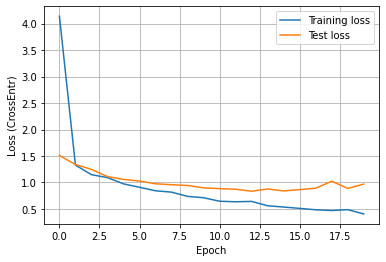

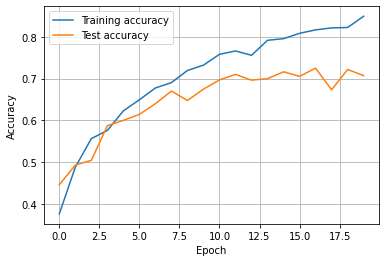

In [5]:
def plotCrssEntr(monitor):
  plt.plot(monitor.model.history.history['loss'], label = 'Training loss')
  plt.plot(monitor.model.history.history['val_loss'], label = 'Test loss')
  plt.xlabel('Epoch'); plt.ylabel('Loss (CrossEntr)')
  plt.legend(); plt.grid(True); plt.show()

def plotAcc(monitor):
  plt.plot(monitor.model.history.history['accuracy'], label = 'Training accuracy')
  plt.plot(monitor.model.history.history['val_accuracy'], label = 'Test accuracy')
  plt.xlabel('Epoch'); plt.ylabel('Accuracy')
  plt.legend(); plt.grid(True); plt.show()

plotCrssEntr(monitor); plotAcc(monitor)

Conf Matirx

In [6]:
def conf(actu, pred):
  y_actu = pd.Series(np.array(actu), name = 'Actual')
  y_pred = pd.Series(pred, name = 'Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion/ df_confusion.sum()

trainConf = conf(y_train, ypred(x_train, monitor.model))
print('Train:\n', trainConf)

testConf = conf(y_test, ypred(x_test, monitor.model))
print('\nTest:\n', testConf)

Train:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.965355  0.014682  0.043023  0.011967  0.077686
CENTURY             0.001174  0.812398  0.023837  0.026926  0.040496
CONSOLAS            0.013506  0.066884  0.851744  0.089753  0.054545
EBRIMA              0.001762  0.064165  0.044767  0.845924  0.037190
GILL                0.018203  0.041871  0.036628  0.025430  0.790083

Test:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.896465  0.012320  0.072727  0.025890  0.124611
CENTURY             0.015152  0.661191  0.029545  0.067961  0.046729
CONSOLAS            0.032828  0.131417  0.709091  0.187702  0.127726
EBRIMA              0.002525  0.137577  0.122727  0.637540  0.093458
GILL                0.053030  0.057495  0.065909  0.080906  0.607477
